In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [3]:
df = pd.read_parquet('../Dataframes/df.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,wclose,delta,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
50,13/3/2000,1.5773,1.5829,1.5761,1.5786,1.579050,0.0,34.042553,29.078014,47.368421,...,1.58335,1.57575,1.579550,1.57950,-1051.660517,-480.169784,-124.552390,-374.380286,-405.042029,-553.768912
51,14/3/2000,1.5786,1.5795,1.5682,1.5787,1.576275,0.0,67.307692,63.253012,51.470588,...,1.58120,1.57215,1.576675,1.57385,-418.016850,-528.634361,-464.546547,-528.940484,-418.450089,-548.468327
52,15/3/2000,1.5787,1.5787,1.5699,1.5733,1.573800,0.0,34.693878,32.692308,30.722892,...,1.57910,1.56905,1.574075,1.57430,-422.252011,-497.671324,-568.730181,-608.062000,-416.686639,-543.624365
53,16/3/2000,1.5733,1.5775,1.5692,1.5765,1.574925,0.0,73.451327,56.462585,53.205128,...,1.57810,1.56955,1.573825,1.57335,-986.842105,-527.622595,-562.098501,-598.903980,-423.601117,-539.882002
54,17/3/2000,1.5765,1.5766,1.5702,1.5753,1.574350,0.0,64.210526,62.831858,48.299320,...,1.57705,1.56970,1.573375,1.57340,-945.945946,-1004.566210,-619.904891,-605.513402,-425.768716,-543.211462


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.head()

,date,high,open,low,close,wclose,delta,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
50,13/3/2000,1.5829,1.5773,1.5761,1.5786,1.579050,0.0,34.042553,29.078014,47.368421,...,1.58335,1.57575,1.579550,1.57950,-1051.660517,-480.169784,-124.552390,-374.380286,-405.042029,-553.768912
51,14/3/2000,1.5795,1.5786,1.5682,1.5787,1.576275,0.0,67.307692,63.253012,51.470588,...,1.58120,1.57215,1.576675,1.57385,-418.016850,-528.634361,-464.546547,-528.940484,-418.450089,-548.468327
52,15/3/2000,1.5787,1.5787,1.5699,1.5733,1.573800,0.0,34.693878,32.692308,30.722892,...,1.57910,1.56905,1.574075,1.57430,-422.252011,-497.671324,-568.730181,-608.062000,-416.686639,-543.624365
53,16/3/2000,1.5775,1.5733,1.5692,1.5765,1.574925,0.0,73.451327,56.462585,53.205128,...,1.57810,1.56955,1.573825,1.57335,-986.842105,-527.622595,-562.098501,-598.903980,-423.601117,-539.882002
54,17/3/2000,1.5766,1.5765,1.5702,1.5753,1.574350,0.0,64.210526,62.831858,48.299320,...,1.57705,1.56970,1.573375,1.57340,-945.945946,-1004.566210,-619.904891,-605.513402,-425.768716,-543.211462


### Change the normalization to be (0, 1)

In [7]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.3 * len(data))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [8]:
input_features

array([[0.41251653, 0.41280745, 0.42930676, ..., 0.46913067, 0.36107467,
        0.21184698],
       [0.40877038, 0.41424773, 0.42065491, ..., 0.41475371, 0.35501519,
        0.21448553],
       [0.40788894, 0.41435852, 0.4225167 , ..., 0.38691739, 0.35581214,
        0.21689679],
       ...,
       [0.08946673, 0.09273211, 0.10984558, ..., 0.66828302, 0.65686441,
        0.62213368],
       [0.08737329, 0.08951917, 0.10447925, ..., 0.65676381, 0.65939083,
        0.62156358],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [9]:
input_data.shape

(5130, 34)

In [10]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

33

In [11]:
input_data

array([[0.41251653, 0.41280745, 0.42930676, ..., 0.46913067, 0.36107467,
        0.21184698],
       [0.40877038, 0.41424773, 0.42065491, ..., 0.41475371, 0.35501519,
        0.21448553],
       [0.40788894, 0.41435852, 0.4225167 , ..., 0.38691739, 0.35581214,
        0.21689679],
       ...,
       [0.08946673, 0.09273211, 0.10984558, ..., 0.66828302, 0.65686441,
        0.62213368],
       [0.08737329, 0.08951917, 0.10447925, ..., 0.65676381, 0.65939083,
        0.62156358],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [12]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data) - test_size - lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [13]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-(test_size+lookback):]

# cut the test data out
X = X[:-(test_size + lookback)]
y = y[:-(test_size + lookback)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(1952, 50, 33)

In [14]:
file = "./Models/" + "Model" + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    # model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7680      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,351
Trainable params: 22,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1952/1952 [==============================] - 4s 2ms/step - loss: 0.0200
Epoch 2/5
1952/1952 [==============================] - 3s 1ms/step - loss: 6.6496e-04
Epoch 3/5
1952/1952 [==============================] - 3s 1ms/step - loss: 5.584

In [15]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size+lookback) + 1:,0]

In [16]:
actual_data = data.iloc[:, 1:].values[-(test_size+lookback) + 1:,0]
actual_data

array([1.6122, 1.5979, 1.6002, ..., 1.2897, 1.2878,    nan])

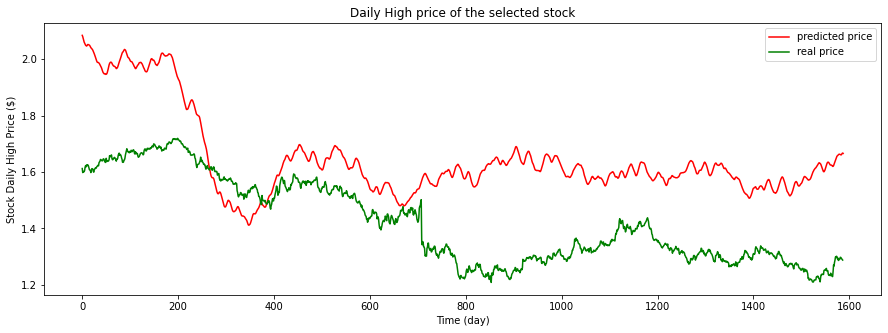

In [17]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [18]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [19]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']

In [20]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 20

In [21]:
frame['wclose'] = data['wclose'].values[-(test_size+lookback) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.6122,2.084160,NaN,NaN,NaN,1.598650,NaN
1,1.5979,2.079797,2.084160,-0.004363,-0.054603,1.595725,-0.001830
2,1.6002,2.072758,2.079797,-0.007040,-0.087985,1.595650,-0.000047
3,1.6018,2.065602,2.072758,-0.007156,-0.089352,1.598275,0.001645
4,1.6009,2.060176,2.065602,-0.005426,-0.067786,1.598000,-0.000172
...,...,...,...,...,...,...,...
1583,1.2946,1.660569,1.660812,-0.000242,-0.003743,1.289750,-0.003631
1584,1.2917,1.662717,1.660569,0.002147,0.033249,1.288600,-0.000892
1585,1.2897,1.665944,1.662717,0.003227,0.050044,1.286275,-0.001804
1586,1.2878,1.667017,1.665944,0.001073,0.016670,1.282625,-0.002838


In [22]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

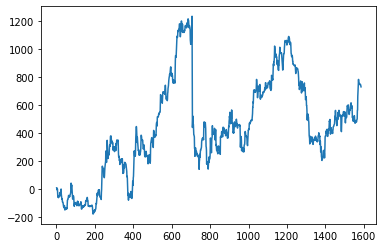

In [24]:
plt.plot(frame['daily_pnl'].cumsum())
plt.show()

In [25]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

0.28229691924911565

In [27]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.1050531914893618